In [1]:
import pickle
import cv2

pickle_data_path = './test_images/dist_pickle.p'
dist_pickle = pickle.load(open(pickle_data_path, 'rb'))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
# cal_col
nx = dist_pickle["nx"]
# cal_row
ny = dist_pickle["ny"]

In [2]:
import numpy as np

# This function is just for initial test. It will be further break down to smaller utility functions

# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
#         Corners dimensionality cal_col (nx) * cal_col (ny)
# In UL, UR, LR, LF (clockwise sequence)
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

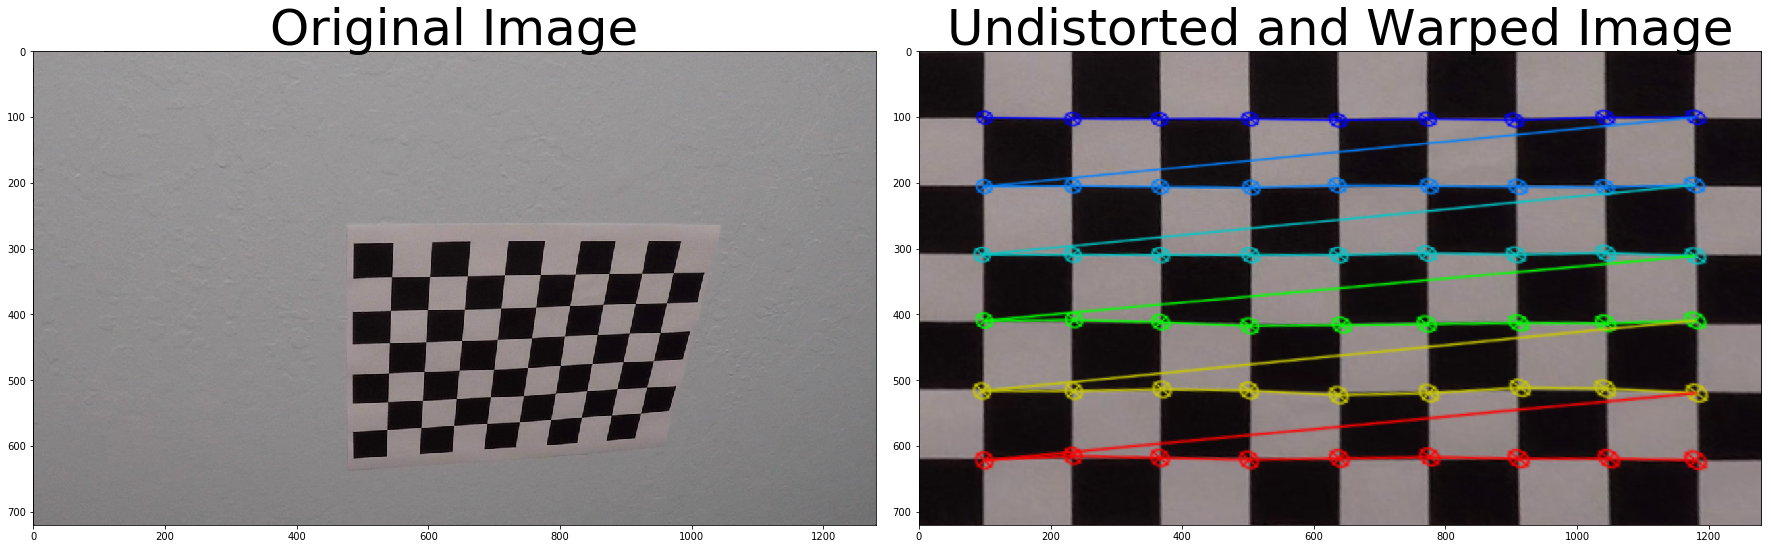

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline
# %matplotlib qt

img_path = './camera_cal/calibration10.jpg'
img = cv2.imread(img_path)
top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)

img_shape = img.shape

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [4]:
    def visualize(filename, a):
        fig, axes = plt.subplots(2,3,figsize=(24,12),subplot_kw={'xticks':[],'yticks':[]})
        fig.subplots_adjust(hspace=0.03, wspace=0.05)
        for p in zip(sum(axes.tolist(),[]), a):
            p[0].imshow(p[1],cmap='gray')
        plt.tight_layout()
        plt.show()
        fig.savefig(filename)
        plt.close()

    def visualize_2(filename, a):
        fig, axes = plt.subplots(1,2,figsize=(12,6),subplot_kw={'xticks':[],'yticks':[]})
        fig.subplots_adjust(hspace=0.03, wspace=0.05)
        for p in zip(axes.tolist(), a):
            p[0].imshow(p[1],cmap='gray')
        plt.tight_layout()
        plt.show()
        fig.savefig(filename)
        plt.close()

### Original Test Images

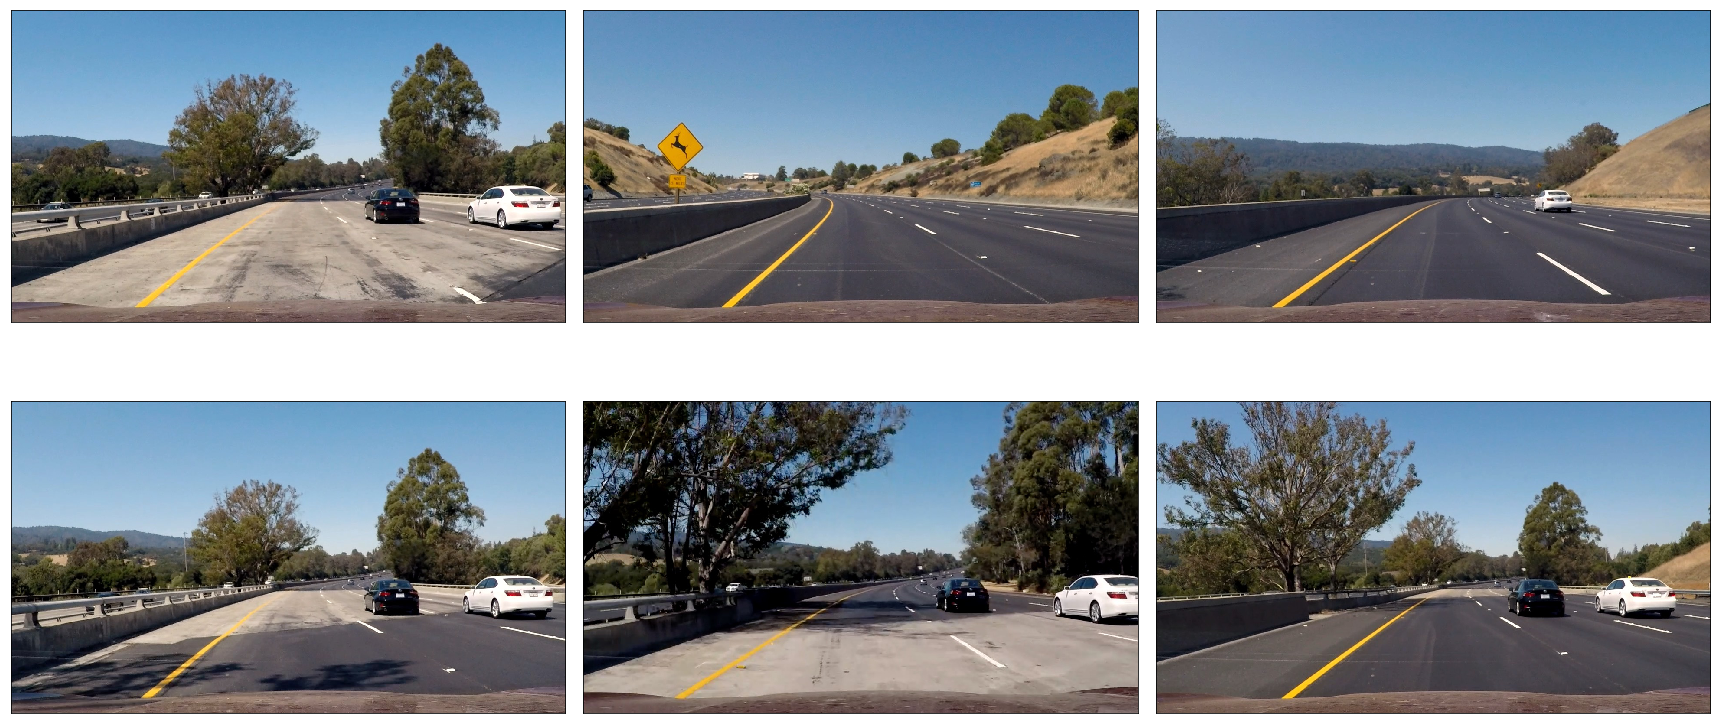

In [5]:
from itertools import cycle
visualize("output_images/test_images.jpg",
            (mpimg.imread(f) for f in cycle(glob.glob("test_images/test*.jpg"))))

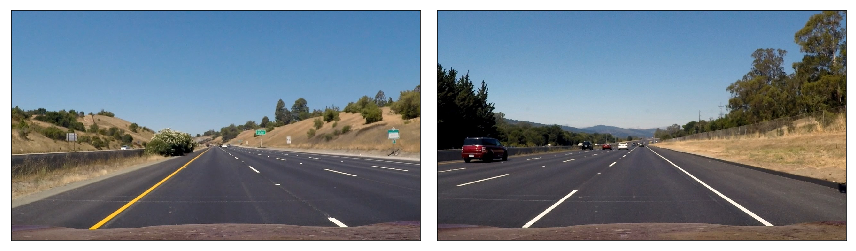

In [6]:
visualize_2("output_images/straight_lines.jpg",
            (mpimg.imread(f) for f in cycle(glob.glob("test_images/straight_lines*.jpg"))))

### Undistorted and Warp Test Images

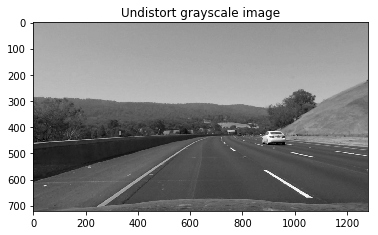

In [7]:
# top_down, perspective_M = corners_unwarp((mpimg.imread(f) for f in cycle(glob.glob("test_images/test*.jpg"))), nx, ny, mtx, dist)

# Interactive plot
# %matplotlib notebook
%matplotlib inline

img_path = './test_images/test3.jpg'
# img = cv2.imread(img_path)
img = mpimg.imread(img_path)
# top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)

def undistort(img, mtx=mtx, dist=dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def undistort_show(img, mtx, dist):
#     undist = cv2.undistort(img, mtx, dist, None, mtx)
    undist = undistort(img, mtx, dist)
    gray = grayscale(undist)
    plt.imshow(gray, cmap='gray')
    plt.title("Undistort grayscale image")

    
# TODO: Matplotlib interactive event handler listen mouse click to record pixel position
undistort_show(img, mtx, dist)

# Manually pick X, Y
# base_points = [[528.482, 501.855], [768.492, 501.855], [1073.01, 705.726], [231.718, 705.726]]

def warped(img, offset=100):
    """
    base_points: [[], [], [], []] four points chosen for forming parallax, vertical and horizontal
    """
#     offset = 100 # offset for dst points
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    (h, w) = (img.shape[0], img.shape[1])

    # For source points I'm grabbing the outer four detected corners
#         Corners dimensionality cal_col (nx) * cal_col (ny)
# In UL, UR, LR, LF (clockwise sequence)
#     src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
    base_points = [[w // 2 - 76, h * .625], [w // 2 + 76, h * .625], [-100, h], [w + 100, h]]
    dst_base_points = [[100, 0], [w - 100, 0], [100, h], [w - 100, h]]
    src = np.float32(base_points)
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = np.float32(dst_base_points)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    return warped, Minv

### Interactively Select parallex points in pictures 

http://matplotlib.org/users/event_handling.html

http://matplotlib.org/1.3.0/examples/event_handling/pick_event_demo.html

 ### Bird Eyes View

In [8]:
warped_img, mat = warped(img)

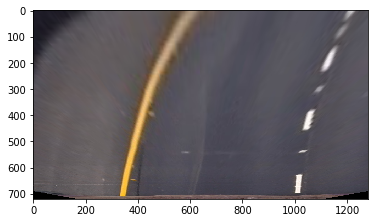

In [9]:
# print(warped_img)
fig1 = plt.figure()
plt.imshow(warped_img)

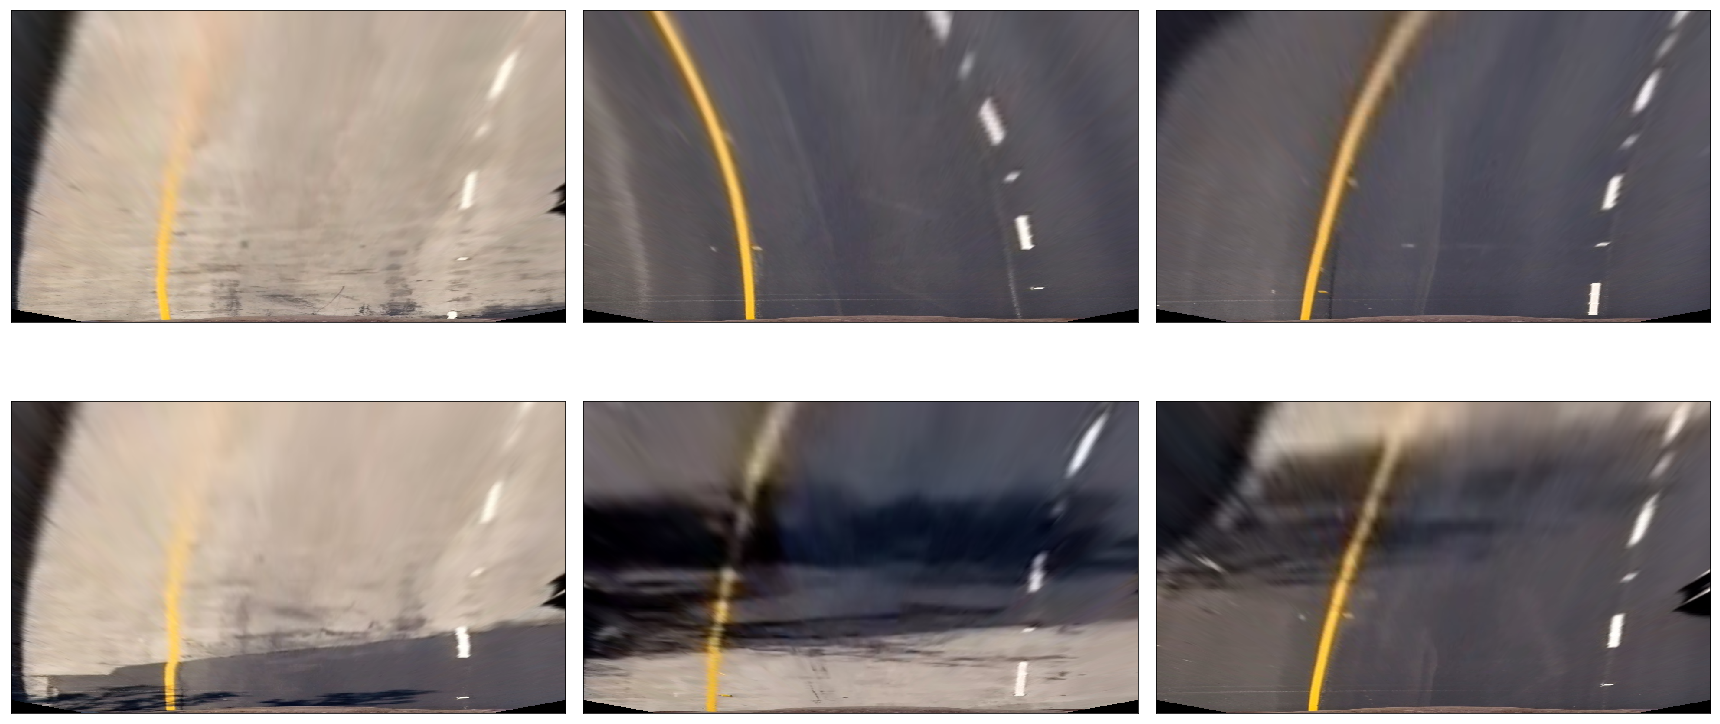

In [10]:
_test_images_len = len(glob.glob("test_images/test*.jpg"))
warped_imgs = np.zeros(shape=(img_shape[0], img_shape[1], img_shape[2], _test_images_len))
# 3 x 3 matrix of a perspective transform
M_perspective = np.zeros(shape=(3, 3, _test_images_len))

# img_path = './test_images/straight_lines2.jpg'
# img = cv2.imread(img_path)

def batch_warp_images(img_generator):
    enum_img = next(img_generator)
    img = mpimg.imread(enum_img[1])
    index = enum_img[0]
    warped_imgs[:, :, :, index] = warped(img)[0]
    M_perspective[:, :, index] = warped(img)[1]

# batch_warp_images((mpimg.imread(f) for f in cycle(glob.glob("test_images/test*.jpg"))))
batch_warp_images((f for f in enumerate(glob.glob("test_images/test*.jpg"))))

visualize("output_images/test_images_warped.jpg", (warped(undistort(mpimg.imread(f)))[0] for f in cycle(glob.glob("test_images/test*.jpg"))))

# print(warped_imgs[:, :, :, 0].shape)
# print(M_perspective[:, :, 0].shape)

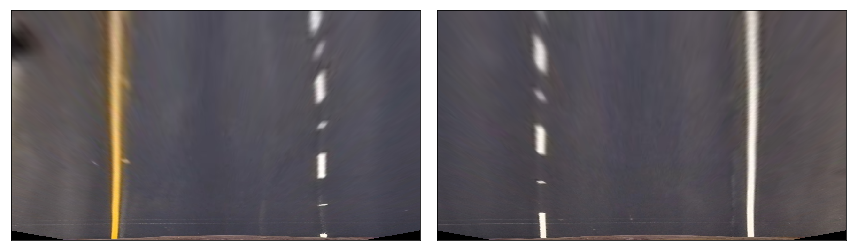

In [11]:
visualize_2("output_images/straight_lines_warped.jpg", (warped(undistort(mpimg.imread(f)))[0] for f in cycle(glob.glob("test_images/straight*.jpg"))))

## Gradient Thresholds

In [12]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def gradient_abs_sobel_mask(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    # Apply the following steps to img
    # 1) Convert to grayscaleure()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # binary_output = np.copy(img) # Remove this line
    return binary_output
    
def gradients_mag_sobel_mask(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def gradients_dir_sobel_mask(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# HLS (Color Space) Masking
Now you can see that, the S channel is still doing a fairly robust job of picking up the lines under very different color and contrast conditions, while the other selections look messy. You could tweak the thresholds and get closer in the other channels, but the S channel is preferable because it is more robust to changing conditions.

It's worth noting, however, that the R channel still does rather well on the white lines, perhaps even better than the S channel. As with gradients, it's worth considering how you might combine various color thresholds to make the most robust identification of the lines.

In [13]:
def color_mask(image, thresh=(0, 255)):
    binary_output = np.zeros_like(image)
    binary_output[(image >= thresh[0]) & (image <= thresh[1])] = 1
    return binary_output

def gbr_to_hls(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2HLS)

def bgr_select(image, i):
    assert (i >= 0 and i <= 2), "b: 0, g: 1, r:2"
    return image[:, :, i]

def hls_select(hls, i):
    assert (i >= 0 and i <= 2), "h: 0, l: 1, s:2"
    return hls[:, :, i]

land = lambda *x: np.logical_and.reduce(x)
lor = lambda *x: np.logical_or.reduce(x)

In [14]:
def edges_mask_image(image, ksize=3):
    '''
        gradient x,
        gradient y,
        mag_binary,
        dir_binary,
        s_channel,
    '''
#     Sharpen the images
#     kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
#     image = cv2.filter2D(image, -1, kernel)
#     fig3 = plt.figure()
#     plt.imshow(image)
    
    # ksize = 3 # Choose a larger odd number to smooth gradient measurements
    gradx = gradient_abs_sobel_mask(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = gradient_abs_sobel_mask(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = gradients_mag_sobel_mask(image, sobel_kernel=ksize, mag_thresh=(20, 100))
    dir_binary = gradients_dir_sobel_mask(image, sobel_kernel=ksize, thresh=(np.pi/4 - 0.1, np.pi/2 + 0.1))
    s_channel_binary = color_mask(hls_select(gbr_to_hls(image), 2), thresh=(170, 255))
    l_channel_binary = color_mask(hls_select(gbr_to_hls(image), 1), thresh=(170, 255))
    r_channel_binary = color_mask(bgr_select(image, 2), thresh=(170, 255))
    g_channel_binary = color_mask(bgr_select(image, 1), thresh=(170, 255))
    
    
#     OpenCV issue
#     http://stackoverflow.com/questions/30249053/python-opencv-drawing-errors-after-manipulating-array-with-numpy
#     It is required to convert output array data type to np.uint8
#     Binary output

#     return lor(land(gradx, grady), land(mag_binary, dir_binary), land(s_channel_binary, lor(r_channel_binary, g_channel_binary)))
#     return lor(land(gradx, grady), land(mag_binary, dir_binary), s_channel_binary)
#     return lor(land(gradx, grady), land(mag_binary, dir_binary), land(s_channel_binary, r_channel_binary))
#     return lor(land(mag_binary, dir_binary), land(s_channel_binary, l_channel_binary))
    return np.array(lor(grady, land(mag_binary, dir_binary), land(s_channel_binary))).astype(np.uint8)

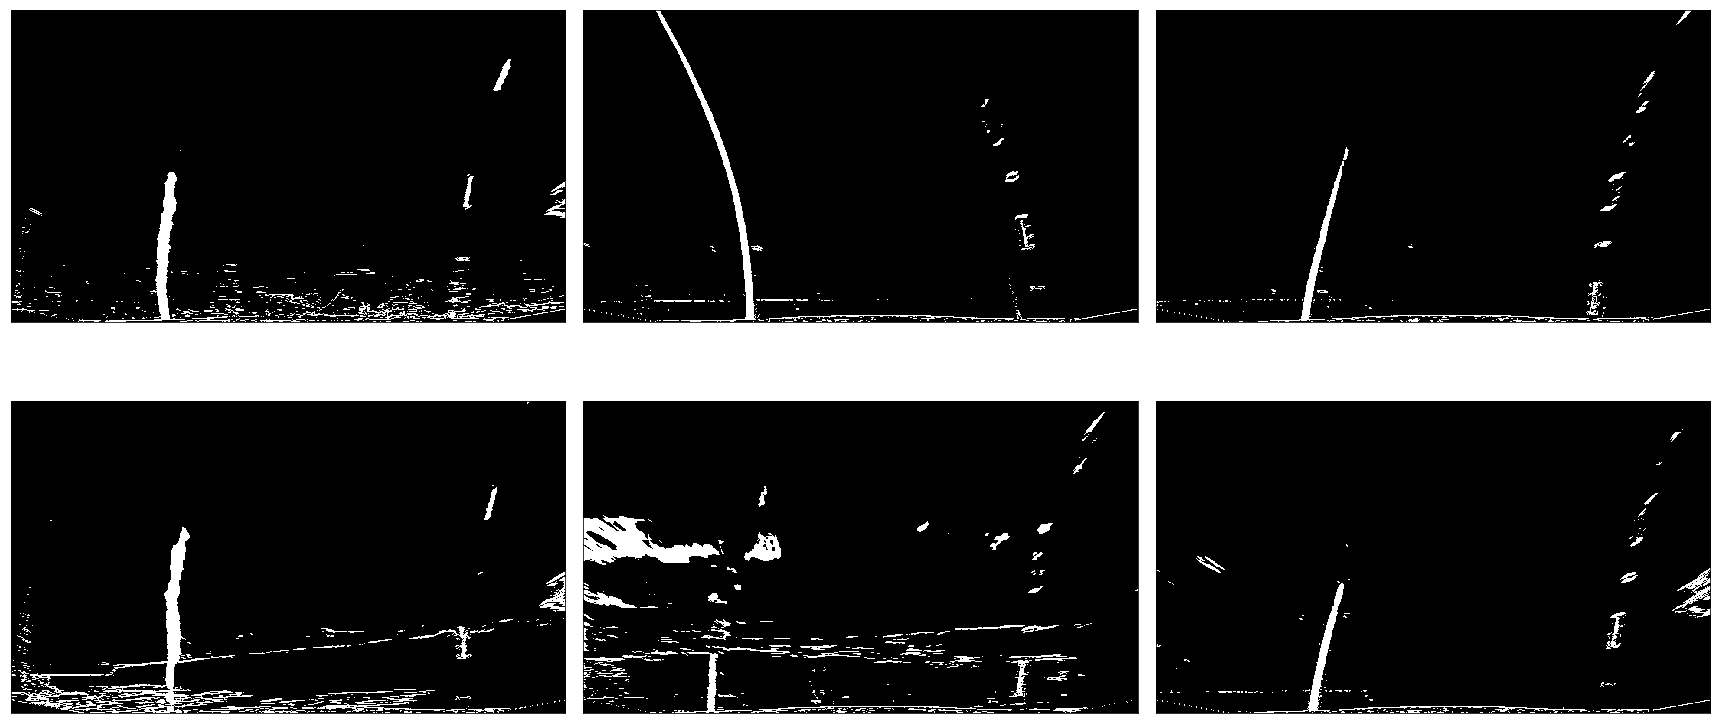

In [15]:
visualize('output_images/test_images_masked.jpg', (edges_mask_image(warped(undistort(cv2.imread(f)))[0]) for f in cycle(glob.glob("test_images/test*.jpg"))))

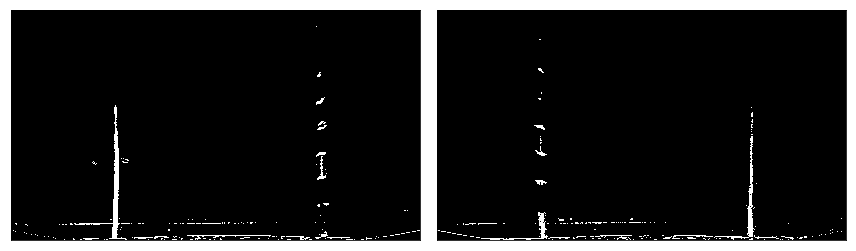

In [16]:
# visualize_2('output_images/straight_lines_masked.jpg', (edges_mask_image(warped(undistort(cv2.imread(f)))[0]) for f in cycle(glob.glob("test_images/straight*.jpg"))))
visualize_2('output_images/straight_lines_masked.jpg', (edges_mask_image(warped(undistort(mpimg.imread(f)))[0]) for f in cycle(glob.glob("test_images/straight*.jpg"))))

## Add independent layer for detection undershadow

In [17]:
## Target test image 5 or 6
# test_image_5

### What works well
Combines R channel? maybe G channel?

In [18]:
# combined = np.zeros_like(image)
# combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
# combined = lor( land(gradx == 1, grady == 1), land(mag_binary == 1, dir_binary == 1))

In [19]:
# plt.imshow(lor(land(gradx, grady), land(mag_binary, dir_binary)), cmap='gray')

## Histogram

/Users/ianzhang/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


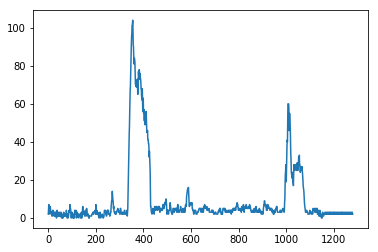

In [20]:
image = edges_mask_image(warped(undistort(img))[0])
histogram = np.sum(image[image.shape[0]/2:,:], axis=0)
plt.plot(histogram)

# fig1 = plt.figure()
# plt.imshow(img)

## Polynomial Fitting
$f(y) = A y^2 + B y + C$

In [21]:
def gen_second_order_curve(h, w, left_fit, right_fit):
    ploty = np.linspace(0, h-1, w)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fitx, right_fitx, ploty

## Sliding Window with second order polynomial fitting

In [22]:
# Not accurate in my case, not using in video tracking

def eval_curve_by_pixels(ploty, leftx, rightx):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m

In [23]:
def detect_lane_line(binary_warped):
    (h, w) = binary_warped.shape
    GREEN = (0, 255, 0)
    RED = [255, 0, 0]
    BLUE = [0, 0, 255]
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
   
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), GREEN, 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), GREEN, 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
#         # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

#     Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    l_fit, r_fit, ploty = gen_second_order_curve(h, w, left_fit, right_fit)
    
#     Visualization
    draw_lane_lines(out_img, left_fit, right_fit, leftx, lefty, rightx, righty)
    return left_fit, right_fit, ploty

def draw_lane_lines(out_img, left_fit, right_fit, leftx, lefty, rightx, righty):
    """
        out_img: lane line dots
    """
    RED = [255, 0, 0]
    BLUE = [0, 0, 255]
    (h, w) = (out_img.shape[0], out_img.shape[1])
    left_fitx, right_fitx, ploty = gen_second_order_curve(h, w, left_fit, right_fit)

    out_img[lefty, leftx] = RED
    out_img[righty, rightx] = BLUE
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, w)
    plt.ylim(h, 0)
    return out_img

/Users/ianzhang/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


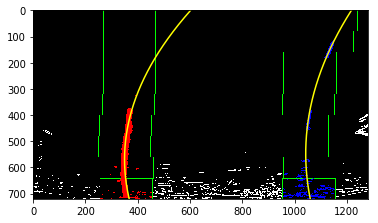

In [24]:
img_path = './test_images/test1.jpg'
# img = cv2.imread(img_path)
img = mpimg.imread(img_path)

l_fit, r_fit, _= detect_lane_line(edges_mask_image(warped(undistort(img))[0]))

In [25]:
def detect_lane_line_skip_window(binary_warped, left_fit, right_fit):
#     left_fit, right_fit
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    (h, w) = binary_warped.shape
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    left_fitx, right_fitx, ploty = gen_second_order_curve(h, w, left_fit, right_fit)
    
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, w)
    plt.ylim(h, 0)
    
    return left_fit, right_fit, ploty

(array([  9.51119167e-04,  -1.06206786e+00,   6.45594478e+02]),
 array([  6.07737512e-04,  -6.58715616e-01,   1.21966580e+03]),
 array([  0.00000000e+00,   5.62157936e-01,   1.12431587e+00, ...,
          7.17875684e+02,   7.18437842e+02,   7.19000000e+02]))

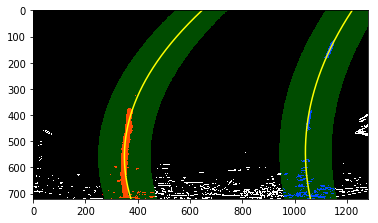

In [26]:
# def draw_lane_lines_with_window(binary_warped, leftx, lefty, rightx, righty):
    # Create an image to draw on and an image to show the selection window
detect_lane_line_skip_window(edges_mask_image(warped(undistort(img))[0]), l_fit, r_fit)

## Sliding Window Search with convolution

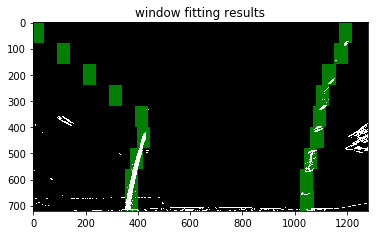

In [27]:
# Read in a thresholded image
img_path = './test_images/test6.jpg'
# img = cv2.imread(img_path)
img = mpimg.imread(img_path)

warped_img = edges_mask_image(warped(undistort(img))[0])
                          
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped_img[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

# window settings
window_width = 50
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

window_centroids = find_window_centroids(warped_img, window_width, window_height, margin)

def draw_lane_lines_with_conv_window(window_centroids, image):
    

#     print(image.shape)
#     print(len(window_centroids))
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(image)
        r_points = np.zeros_like(image)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,image,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,image,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channle 
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
#         warpage = np.array(cv2.merge((image,image,image)),np.uint8) # making the original road pixels 3 color channels
        warpage = np.dstack((image, image, image))*255
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

        # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((image,image,image)),np.uint8)
    return output

output = draw_lane_lines_with_conv_window(window_centroids, warped_img)
# Display the final results
fig2 = plt.figure()
plt.imshow(output)
plt.title('window fitting results')
plt.show()

## Measuring Curvature

At any point x of the function $x = f(y)$

$R_{curve} = \frac{\big[1 + (\frac{dx}{dy})^2 \big]^\frac{3}{2}}{|\frac{d^2x}{dy^2}|}$

$f(y) = A y^2 + B y + C$

Plugging into first and second order of derivatives

$R_{curve} = \frac{\big[1 + (2Ay + B)^2 \big]^\frac{3}{2}}{|2A|}$

/Users/ianzhang/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


774.811314695 1299.34074354


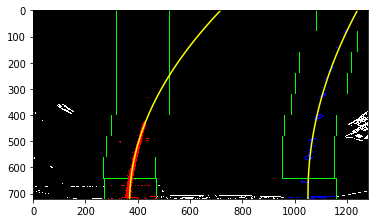

In [28]:
def eval_curve(ploty, left_fit, right_fit):
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
#     print(left_curverad, right_curverad)
    return left_curverad, right_curverad

l_fit, r_fit, ploty = detect_lane_line(edges_mask_image(warped(undistort(img))[0]))
left_curverad, right_curverad = eval_curve(ploty, l_fit, r_fit)

print(left_curverad, right_curverad)

## TODO

Image center offset

Video Tracking

## Utility functions

In [29]:
def draw_text(img, text, pos=(10, 50), color=(255, 255, 255)):
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, text, pos, font, 2, color, 2, cv2.LINE_AA)

In [30]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = []
        self.MAX_Q_LEN = 37
        self.q_len = 0
        #average x values of the fitted line over the last n iterations
#         tuple of x points
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
#         self.current_fit = [np.array([False])]  
        self.current_fit = []
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
    
    def lane_detector(self, frame):
        """
            Procedure: 
                1. Undistort
                2. Warp
                3. Mask_non_edges
                4. Detect lane lines
                5. Draw line lines
        """
        undistorted_image = undistort(frame)
        warped_image, Minv = warped(undistorted_image)
        masked_image = edges_mask_image(warped_image)
        (h, w) = masked_image.shape
#         if self.detected:
#             left_fit, right_fit, result = self.detect_lane_line_(self, masked_image)
#             process_curr_frame(h, w, left_fit, right_fit)
#             return result
        
#         left_fit, right_fit, result = self.detect_lane_line_skip_window_(self, self.current_fit[0], self.current_fit[1])
#         process_curr_frame(h, w, left_fit, right_fit)

        left_fit, right_fit, result = self.detect_lane_line_(masked_image, Minv, undistorted_image)
        return result

#     State change
    def process_curr_frame(self, h, w, left_fit, right_fit):
        self.current_fit = [np.array(left_fit), np.array(right_fit)]
        self.recent_xfitted.append([left_fit, right_fit])
        
        self.q_len += 1

        if self.q_len >= self.MAX_Q_LEN:
            self.recent_xfitted.pop(0)
#         Average
        self.best_fit = np.mean(self.recent_xfitted, axis=0)
        left_fit, right_fit = self.best_fit[0], self.best_fit[1]
        self.bestx = gen_second_order_curve(h, w, left_fit, right_fit)
        return self

    def draw_lane_lines_(self, out_img, left_fit, right_fit, leftx, lefty, rightx, righty):
        """
            out_img: lane line dots
        """
        RED = [255, 0, 0]
        BLUE = [0, 0, 255]
        YELLOW = [255, 255, 0]
        (h, w) = (out_img.shape[0], out_img.shape[1])
        left_fitx, right_fitx, ploty = gen_second_order_curve(h, w, left_fit, right_fit)

        out_img[lefty, leftx] = RED
        out_img[righty, rightx] = BLUE
        
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        
        out_img[lefty, leftx] = RED
        out_img[righty, rightx] = BLUE
        
        cv2.fillPoly(out_img, np.int_([pts]), (0,255, 0))
        return out_img



    def detect_lane_line_(self, binary_warped, Minv, undist):
        (h, w) = binary_warped.shape
        GREEN = (0, 255, 0)
        RED = [255, 0, 0]
        BLUE = [0, 0, 255]
        histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), GREEN, 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), GREEN, 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    #         # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

    #     Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

#         if not leftx or not lefty or not rightx or not righty:
#             self.detected = False
# #             Return last good one
#             return self.best_fit[0], self.best_fit[1]
#         self.detected = True        
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
#         l_fit, r_fit, ploty = gen_second_order_curve(h, w, left_fit, right_fit)
        
        #-----------------------------------------------------
        # Smoothed curvatures
        #-----------------------------------------------------
        self.process_curr_frame(h, w, left_fit, right_fit)
        left_fit, right_fit = self.best_fit[0], self.best_fit[1]
#         print(self.best_fit[0].shape)
    #     Visualization
        color_warp = self.draw_lane_lines_(out_img, left_fit, right_fit, leftx, lefty, rightx, righty)
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
        
        
        #-----------------------------------------------------
        # Calculate curvatures
        #-----------------------------------------------------
        l_fit, r_fit, ploty = gen_second_order_curve(h, w, left_fit, right_fit)
        self.radius_of_curvature = eval_curve(ploty, left_fit, right_fit)
        # Check curvature direction
        curvature = self.radius_of_curvature
        draw_text(result, "Estimated curvature", pos=(10, 80))
        draw_text(result, "Left: " + str(np.round(curvature[0])), pos=(10, 140))
        draw_text(result, "Right:" + str(np.round(curvature[1])), pos=(10, 200))
        
        return left_fit, right_fit, result
    def detect_lane_line_skip_window_(self, binary_warped, left_fit, right_fit):
        #     left_fit, right_fit
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        (h, w) = binary_warped.shape
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100

        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        if not leftx or not lefty or not rightx or not righty:
            self.detected = False
            return self.best_fit[0], self.best_fit[1]
        self.detected = True
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        left_fitx, right_fitx, ploty = gen_second_order_curve(h, w, left_fit, right_fit)

        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
#         plt.imshow(result)
#         plt.plot(left_fitx, ploty, color='yellow')
#         plt.plot(right_fitx, ploty, color='yellow')
#         plt.xlim(0, w)
#         plt.ylim(h, 0)

        return left_fit, right_fit, result

In [31]:
tracker = Line()

In [32]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'output.mp4'
project_video = VideoFileClip("./project_video.mp4")
# output_clip = project_video.fl
project_clip = project_video.fl_image(tracker.lane_detector)
%time project_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [07:10<00:00,  3.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 5min 27s, sys: 1min 31s, total: 6min 58s
Wall time: 7min 12s
